In [1]:
# import libraries
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Set our plot styles
sns.set_theme()
sns.set_context("paper")

In [2]:
# Load the dataset
df = pd.read_csv("data/loan_data.csv")
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [3]:
## data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [4]:
## Check for missing values and duplicates
df.isnull().sum(), df.duplicated().sum()

(person_age                        0
 person_gender                     0
 person_education                  0
 person_income                     0
 person_emp_exp                    0
 person_home_ownership             0
 loan_amnt                         0
 loan_intent                       0
 loan_int_rate                     0
 loan_percent_income               0
 cb_person_cred_hist_length        0
 credit_score                      0
 previous_loan_defaults_on_file    0
 loan_status                       0
 dtype: int64,
 np.int64(0))

## EDA

In [19]:
## Plot settings
cls = "#54b200"

## Create a list of numeric columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

In [23]:
def plot_histograms(df, num_cols):
    for col in num_cols:
        plt.figure(figsize=(12, 6))
        
        # Dynamic bin calculation based on data distribution
        q75, q25 = np.percentile(df[col], [75, 25])
        iqr = q75 - q25
        bin_width = 2 * iqr / (len(df[col]) ** (1/3))  # Freedman-Diaconis rule
        bins = int((df[col].max() - df[col].min()) / bin_width) if bin_width > 0 else 30
        bins = min(max(bins, 10), 100)  # Limit bins between 10 and 100
        
        # Create histogram with improved styling
        sns.histplot(df[col], bins=bins, kde=True, color=cls, alpha=0.7, 
                    edgecolor='white', linewidth=1.2)
        
        # Add statistics text
        mean_val = df[col].mean()
        median_val = df[col].median()
        std_val = df[col].std()
        
        plt.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.2f}')
        plt.axvline(median_val, color='orange', linestyle='--', alpha=0.8, label=f'Median: {median_val:.2f}')
        
        # Styling improvements
        plt.title(f"Distribution of {col.replace('_', ' ').title()}", fontsize=16, fontweight='bold', pad=20)
        plt.xlabel(col.replace('_', ' ').title(), fontsize=12, fontweight='bold')
        plt.ylabel("Frequency", fontsize=12, fontweight='bold')
        plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
        plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        plt.tight_layout()
        
        # Add subtle background color
        plt.gca().set_facecolor('#f8f9fa')
        
        plt.show()

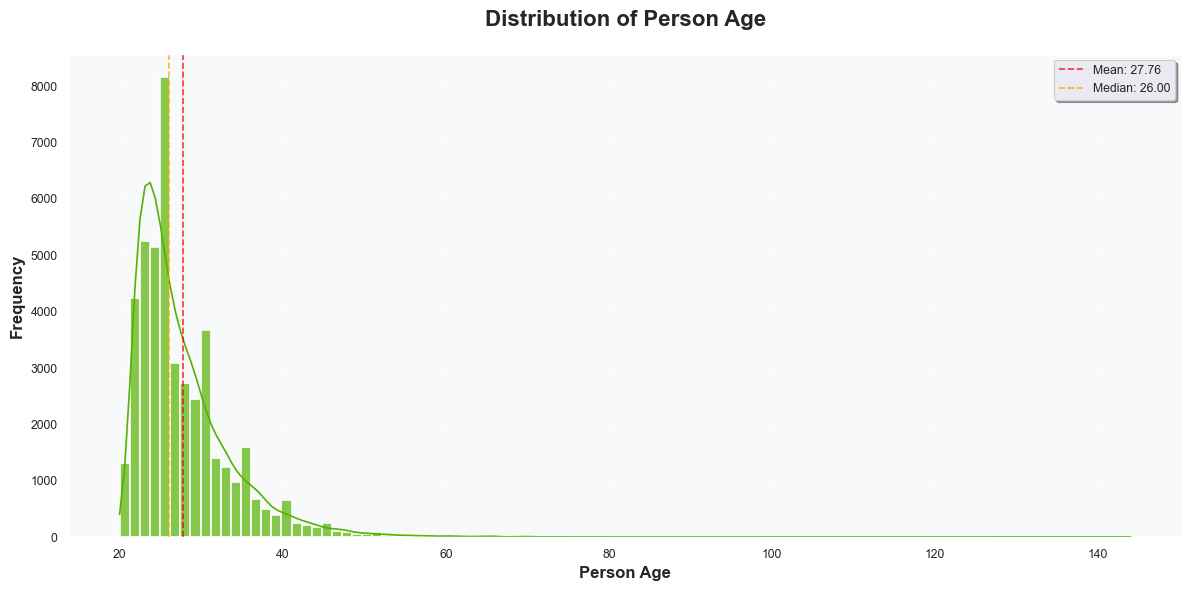

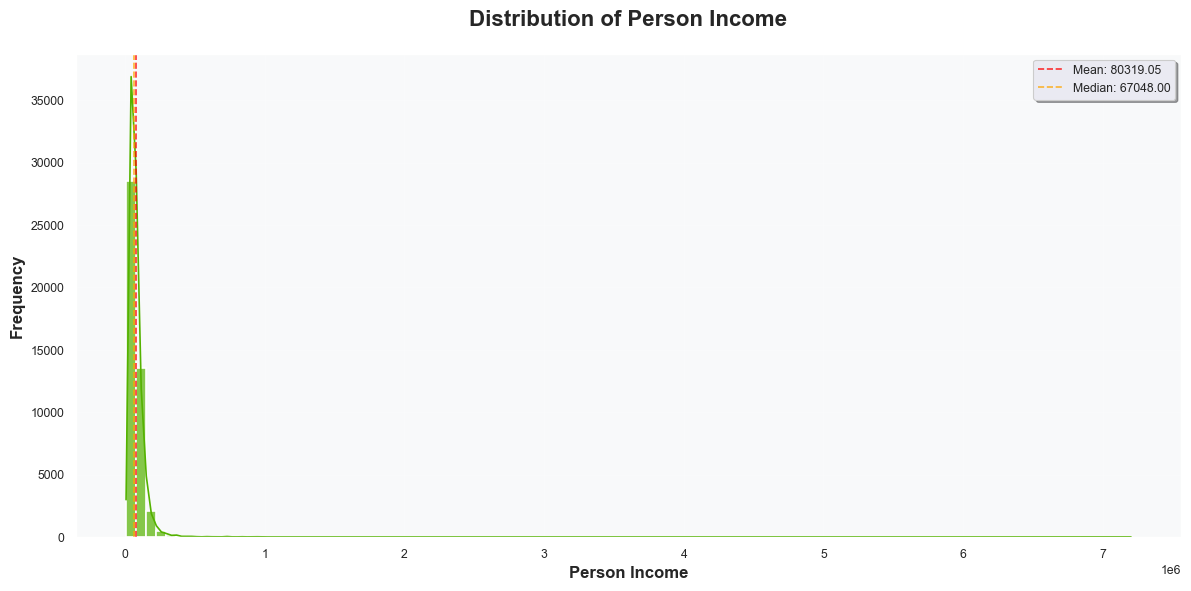

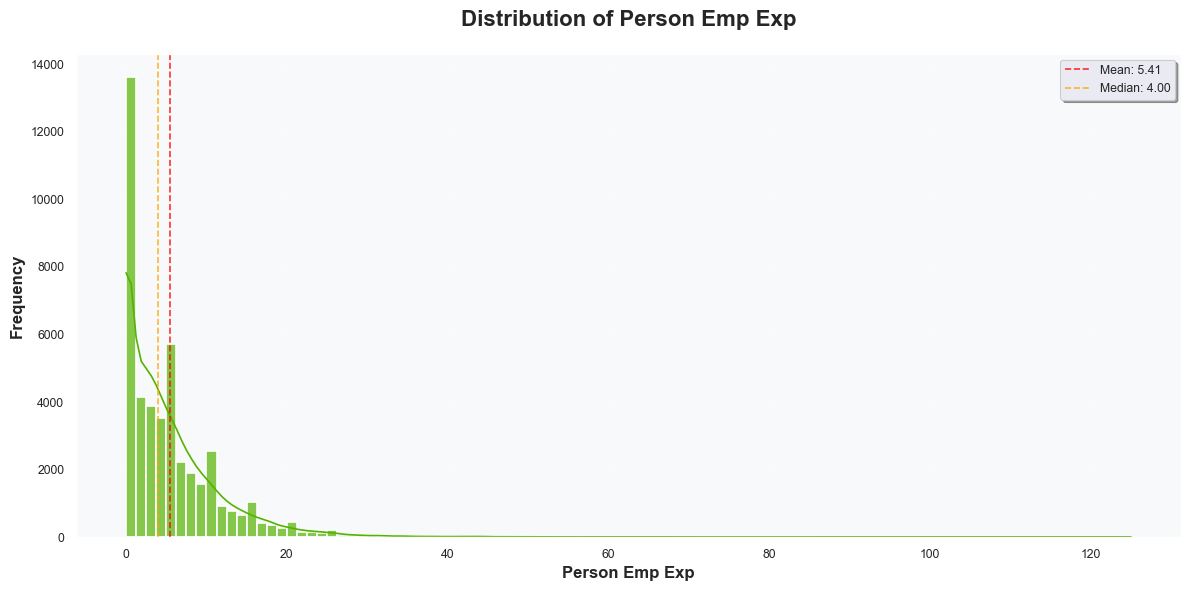

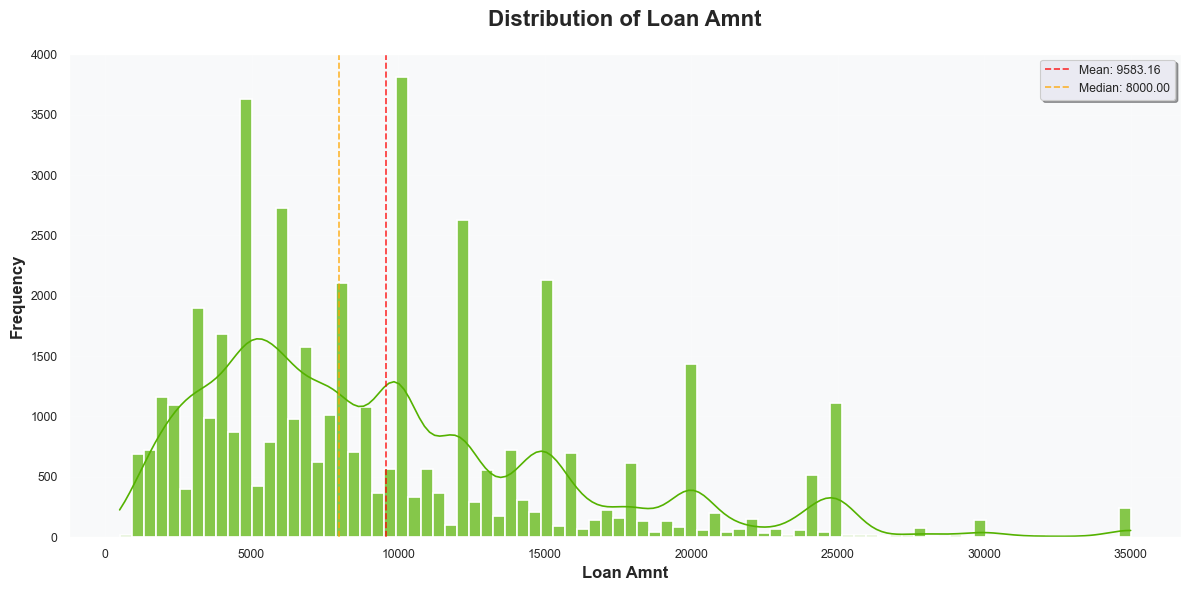

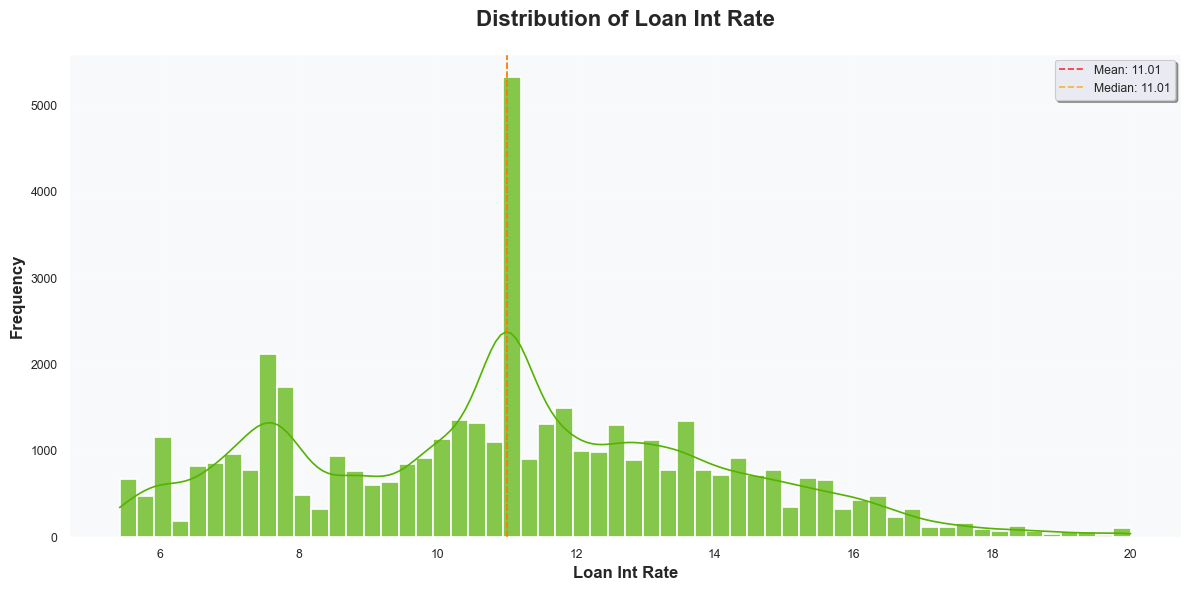

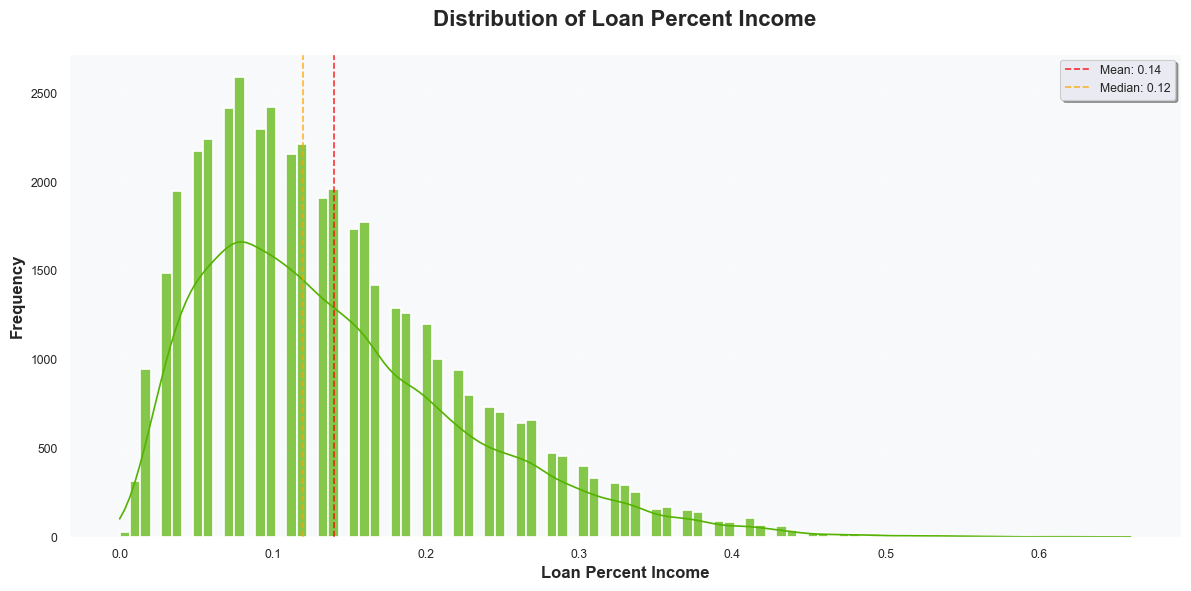

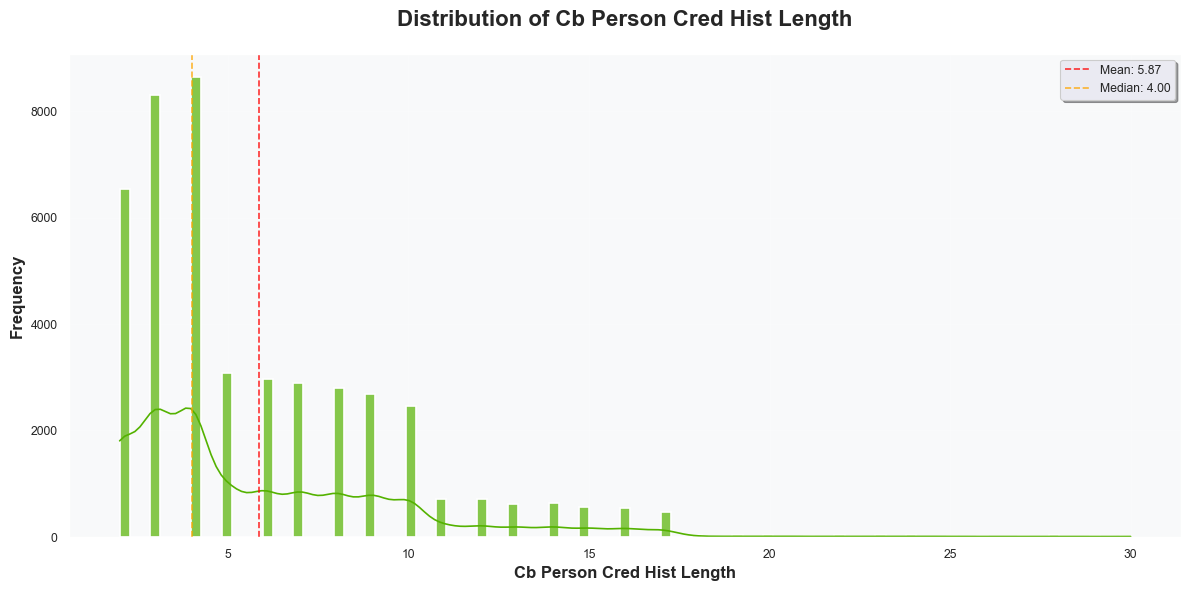

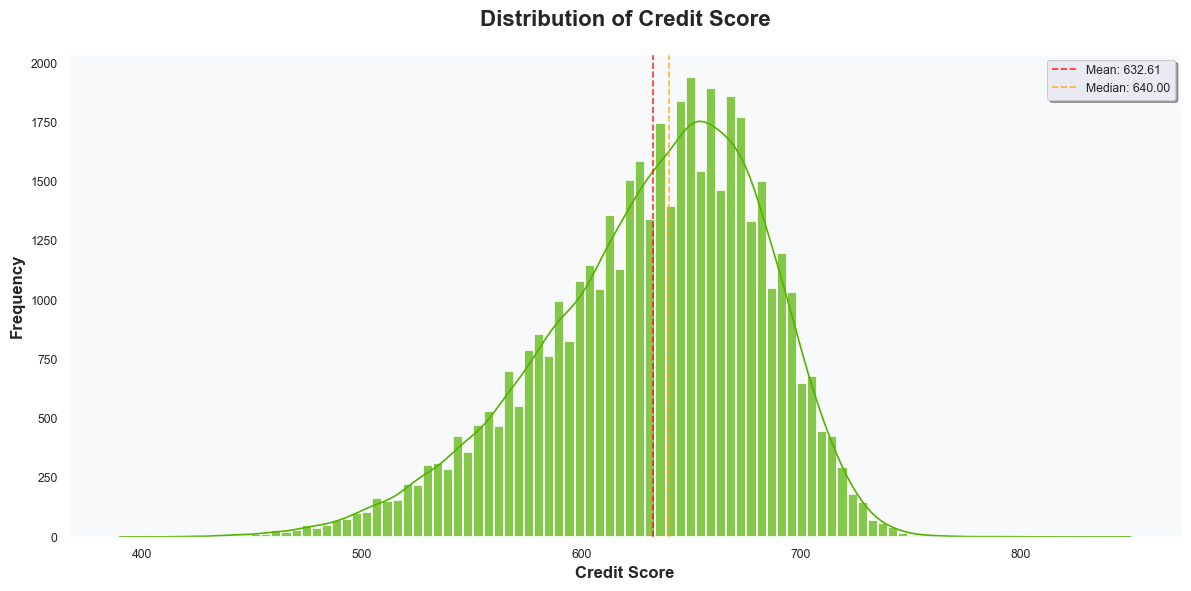

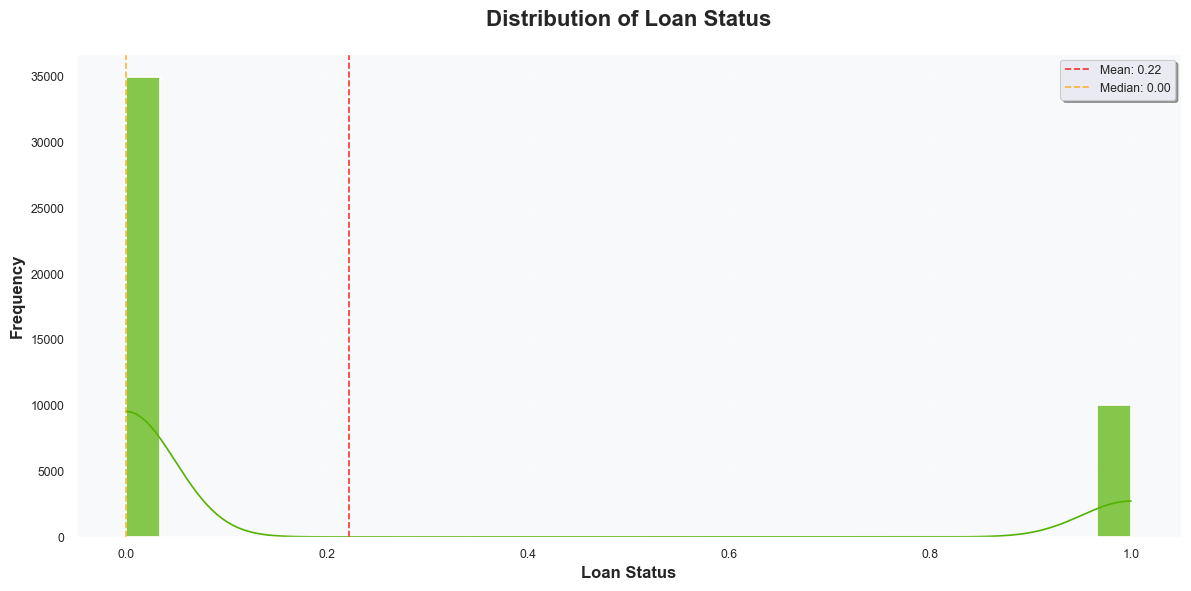

In [24]:
plot_histograms(df, num_cols)

In [25]:
## Create a function to plot count plots for categorical variables
def plot_count_plots(df, cat_cols):
    for col in cat_cols:
        plt.figure(figsize=(12, 6))
        
        # Create count plot with improved styling
        sns.countplot(data=df, x=col, palette='Set2', edgecolor='black', linewidth=1.2)
        
        # Add percentage labels on top of bars
        total = len(df[col])
        for p in plt.gca().patches:
            height = p.get_height()
            percentage = f'{(height / total) * 100:.1f}%'
            plt.text(p.get_x() + p.get_width() / 2., height + 0.02 * total, percentage,
                     ha='center', va='bottom', fontsize=10, color='black')
        
        # Styling improvements
        plt.title(f"Count of {col.replace('_', ' ').title()}", fontsize=16, fontweight='bold', pad=20)
        plt.xlabel(col.replace('_', ' ').title(), fontsize=12, fontweight='bold')
        plt.ylabel("Count", fontsize=12, fontweight='bold')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
        plt.tight_layout()
        
        # Add subtle background color
        plt.gca().set_facecolor('#f8f9fa')
        
        plt.show()

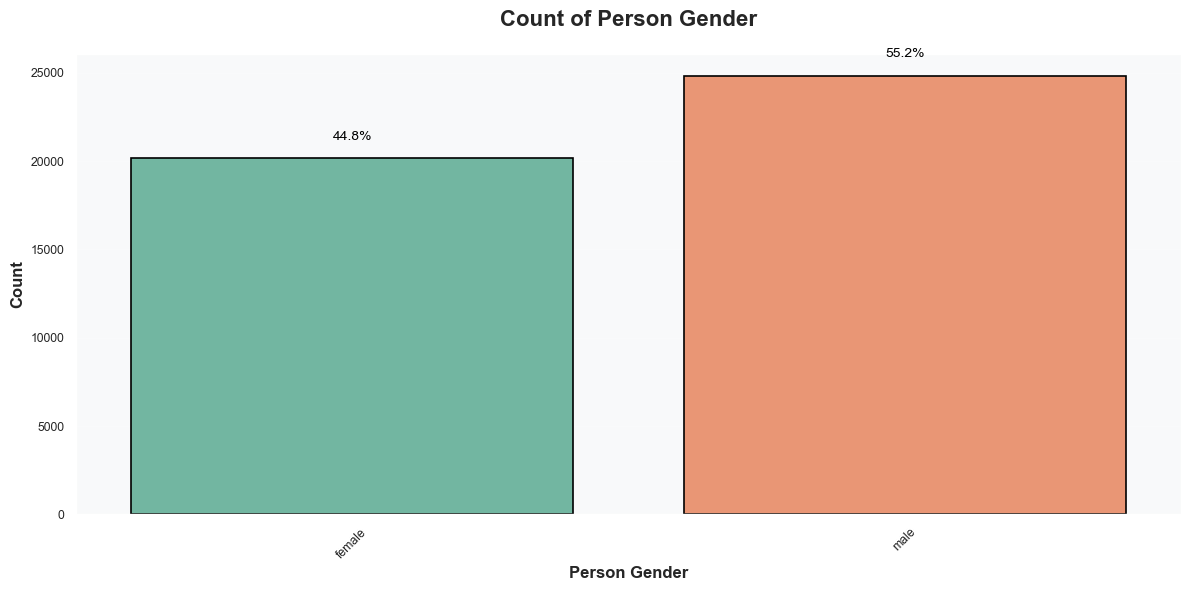

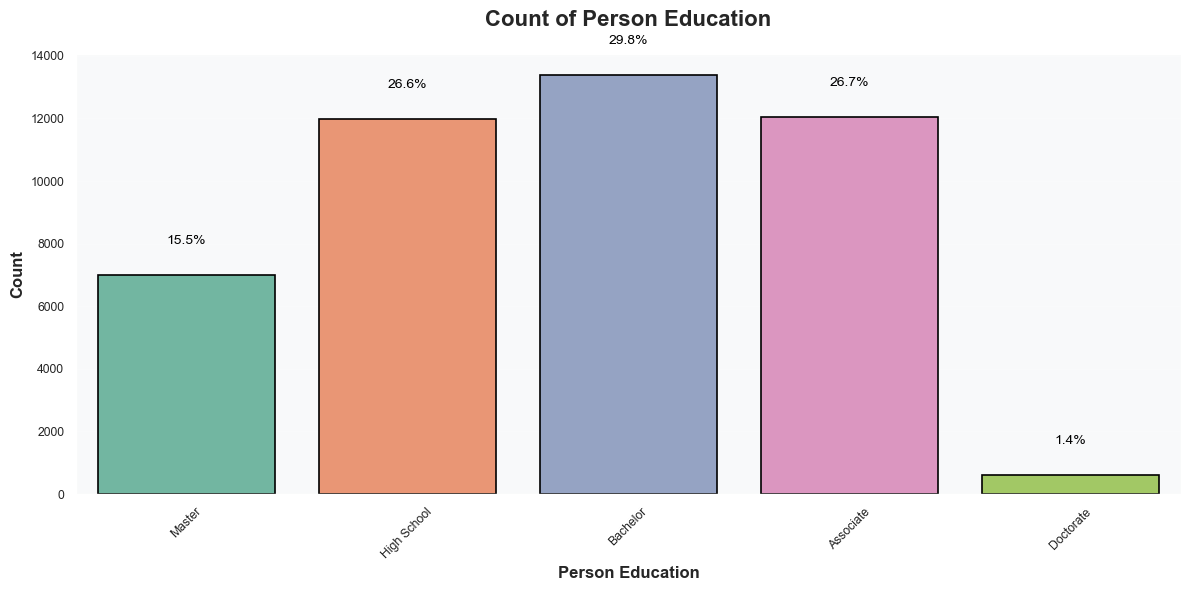

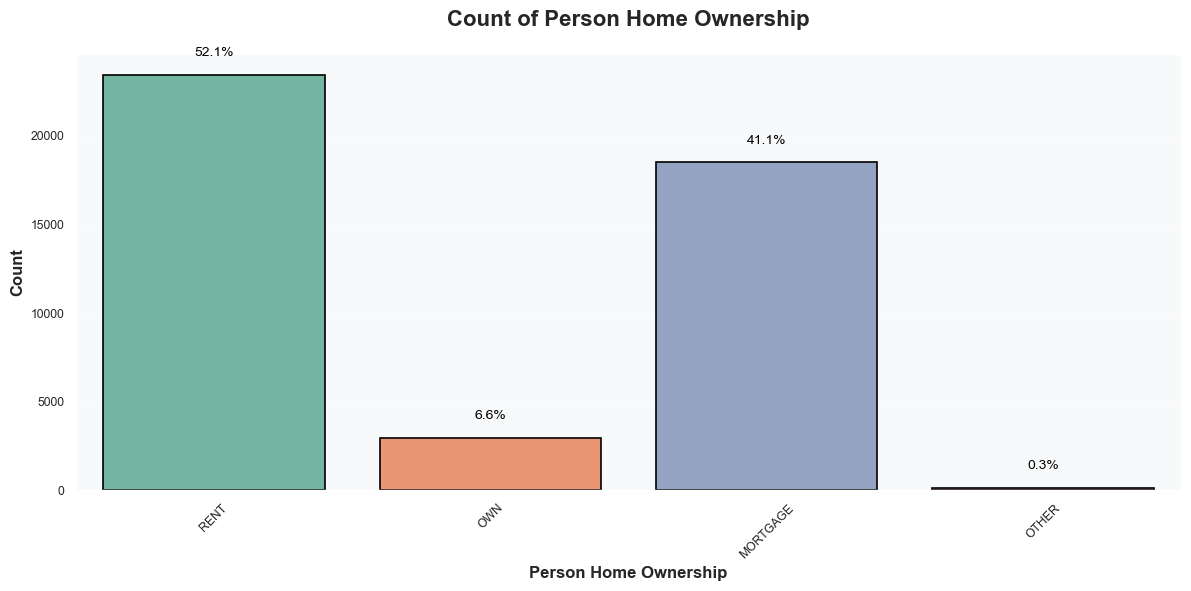

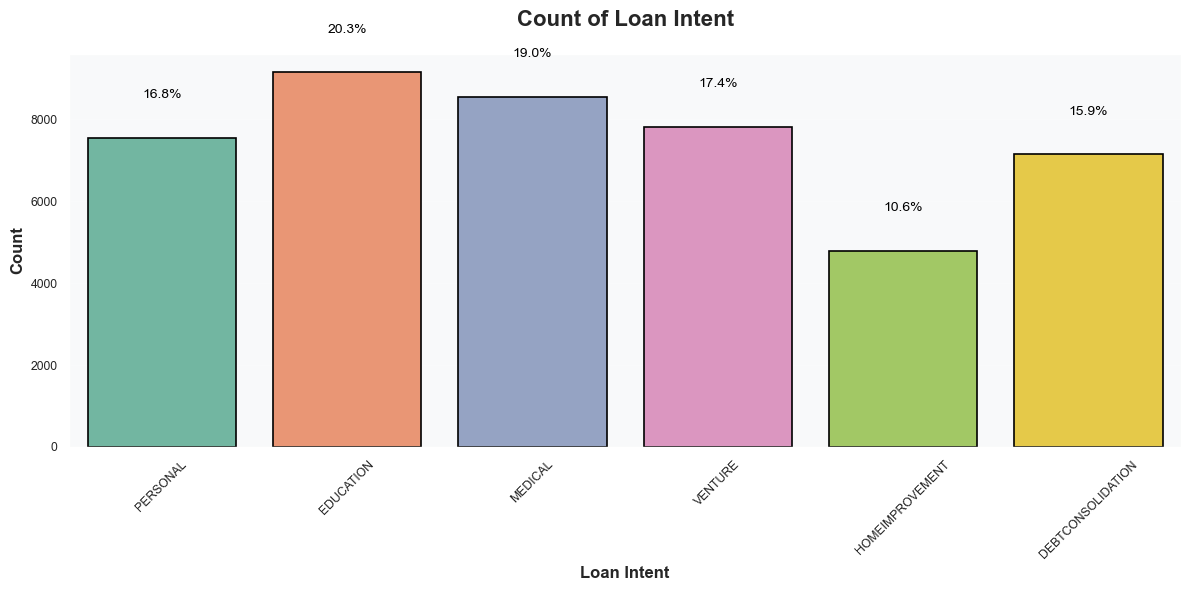

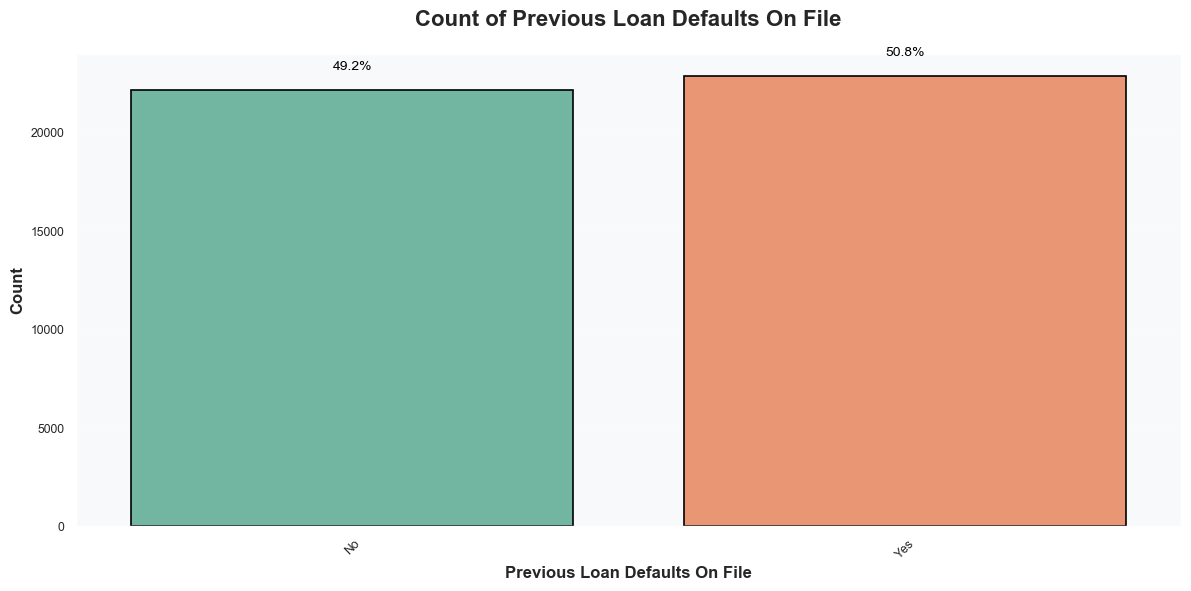

In [26]:
plot_count_plots(df, cat_cols)

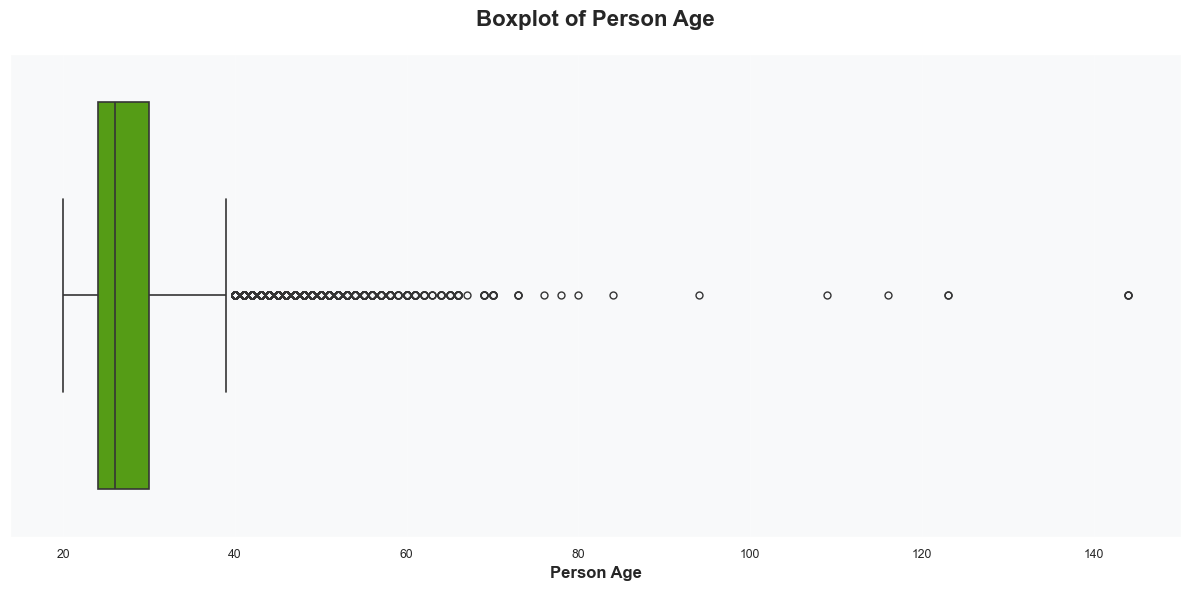

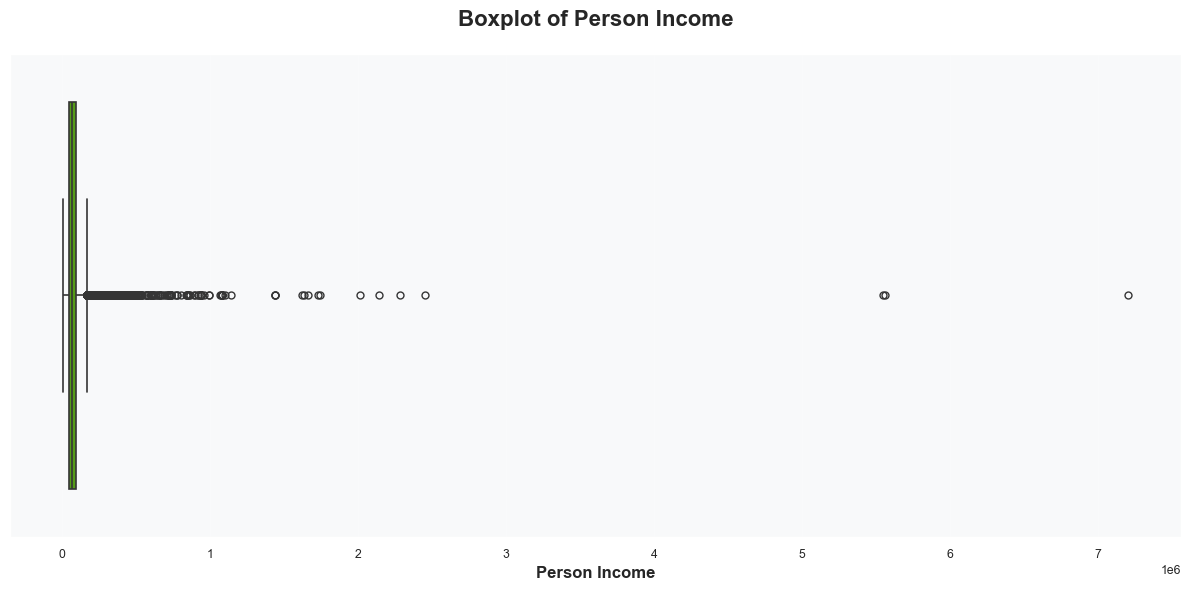

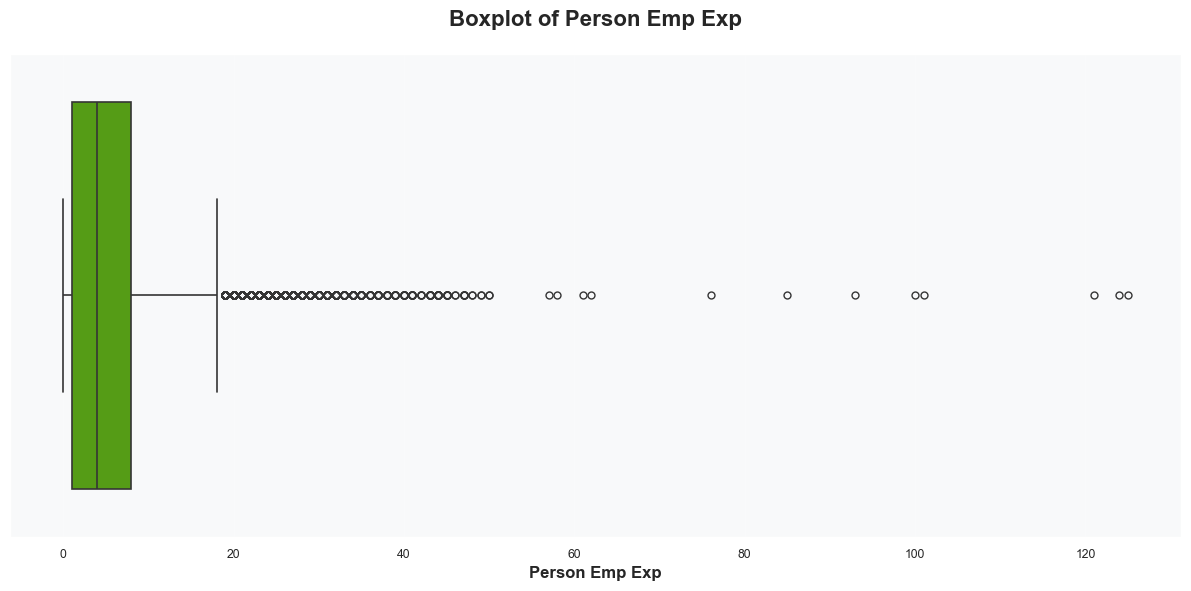

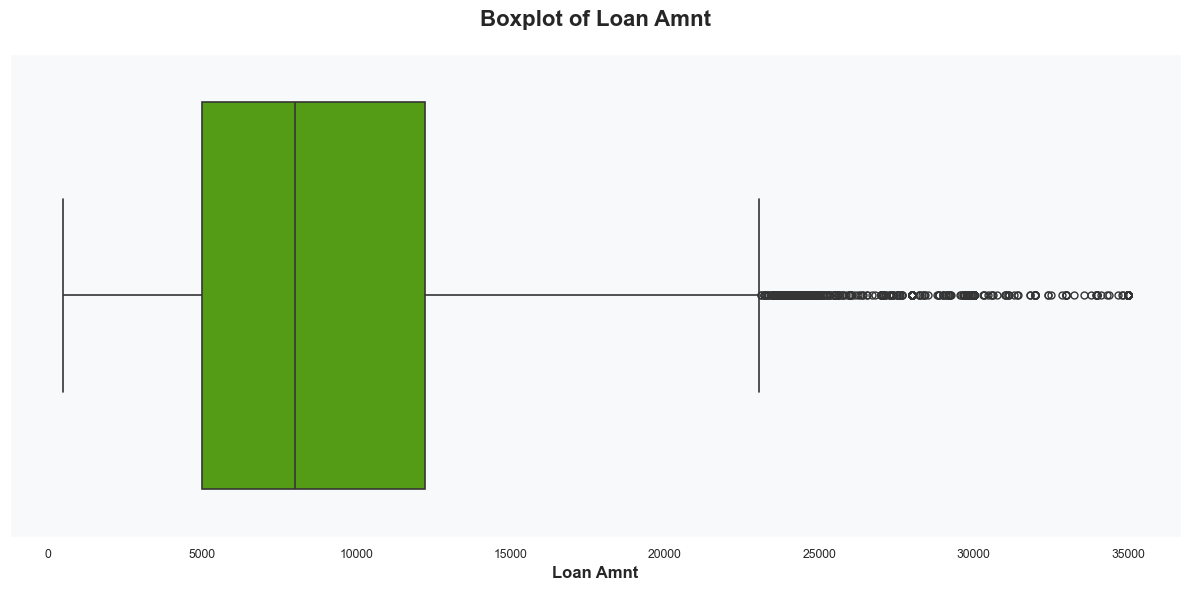

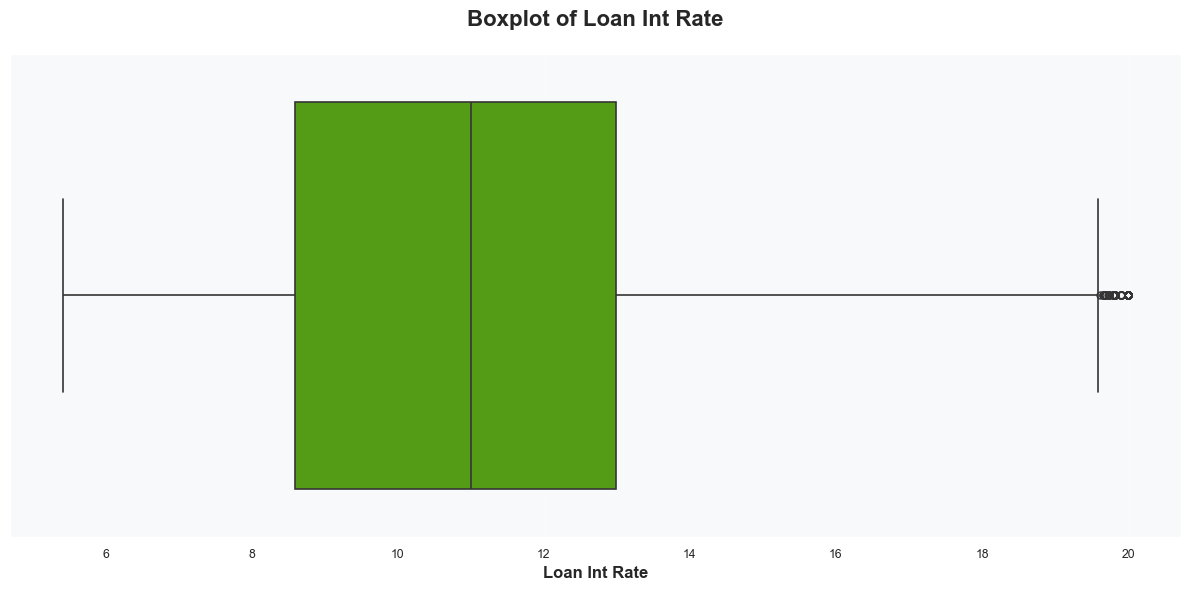

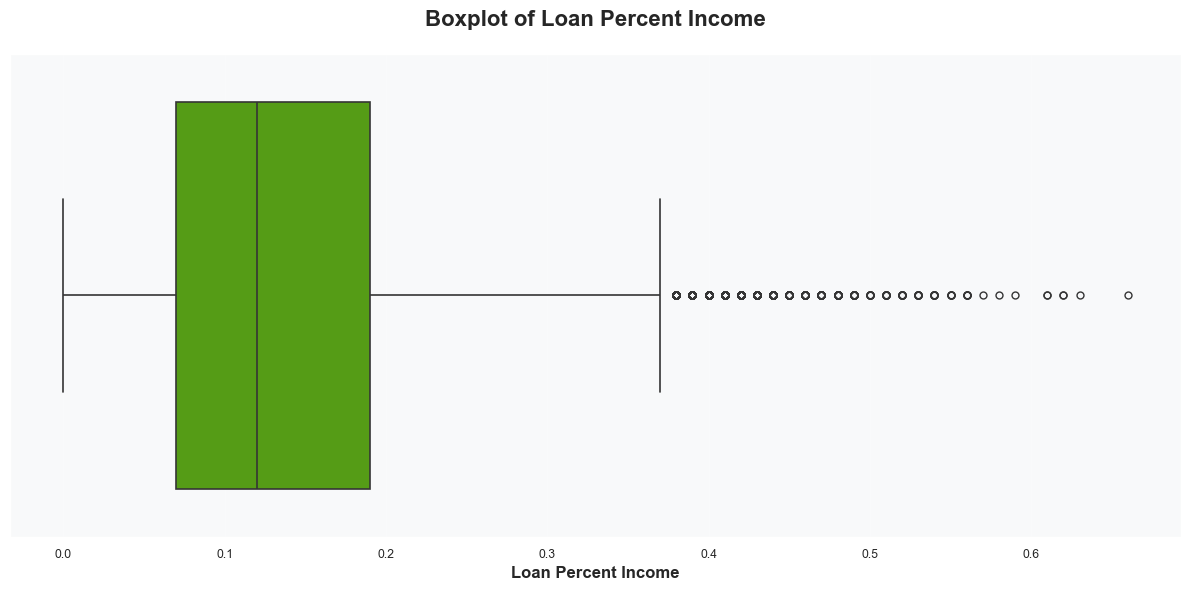

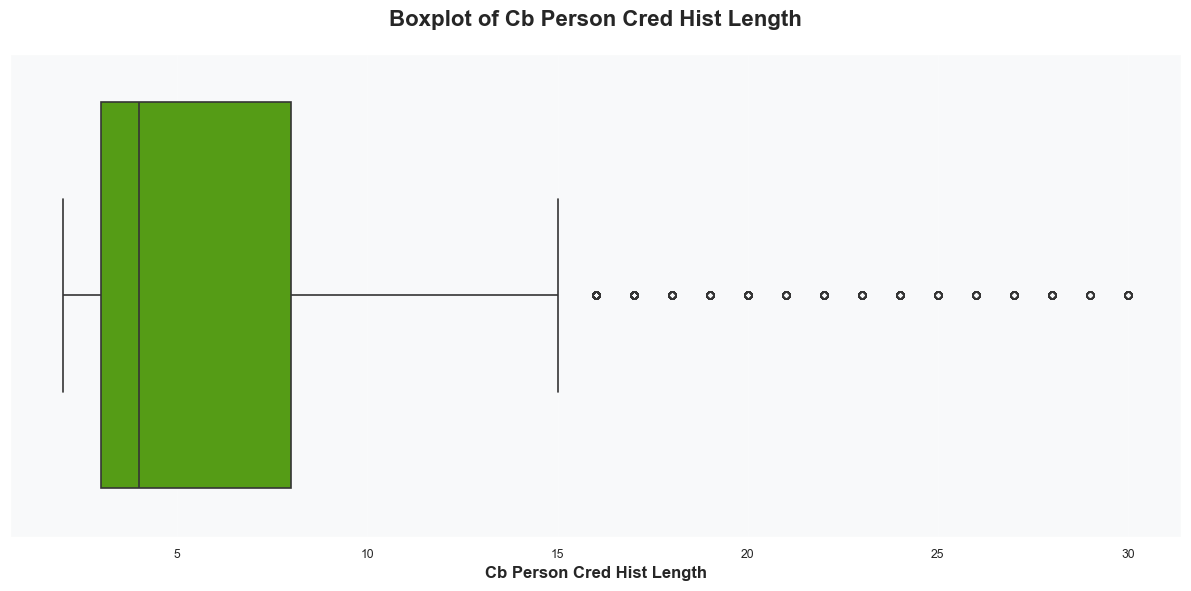

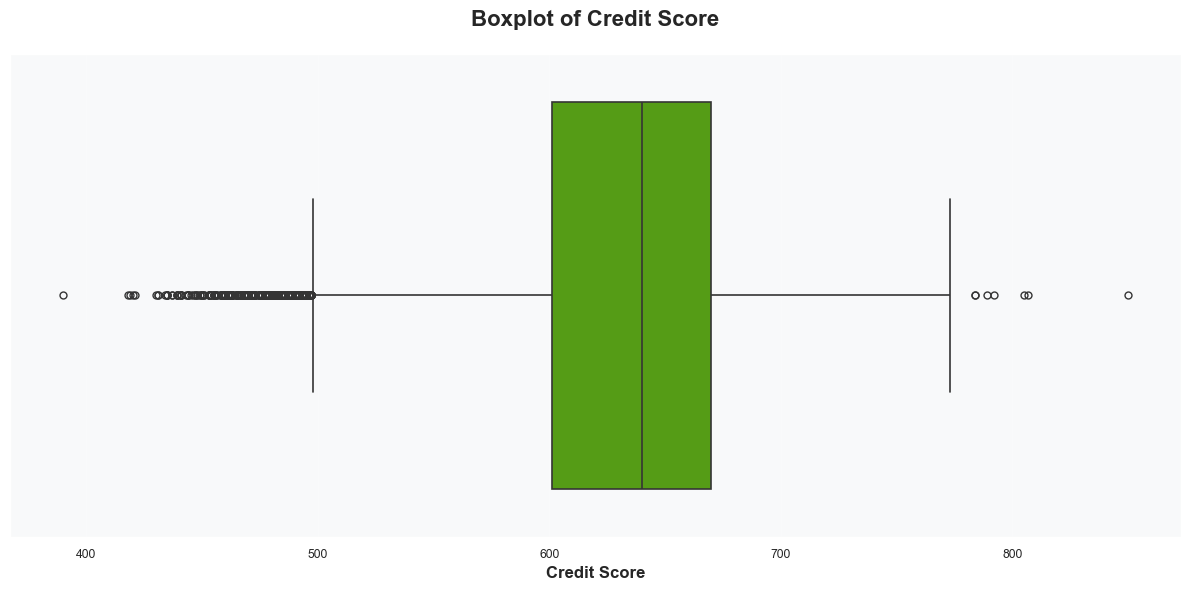

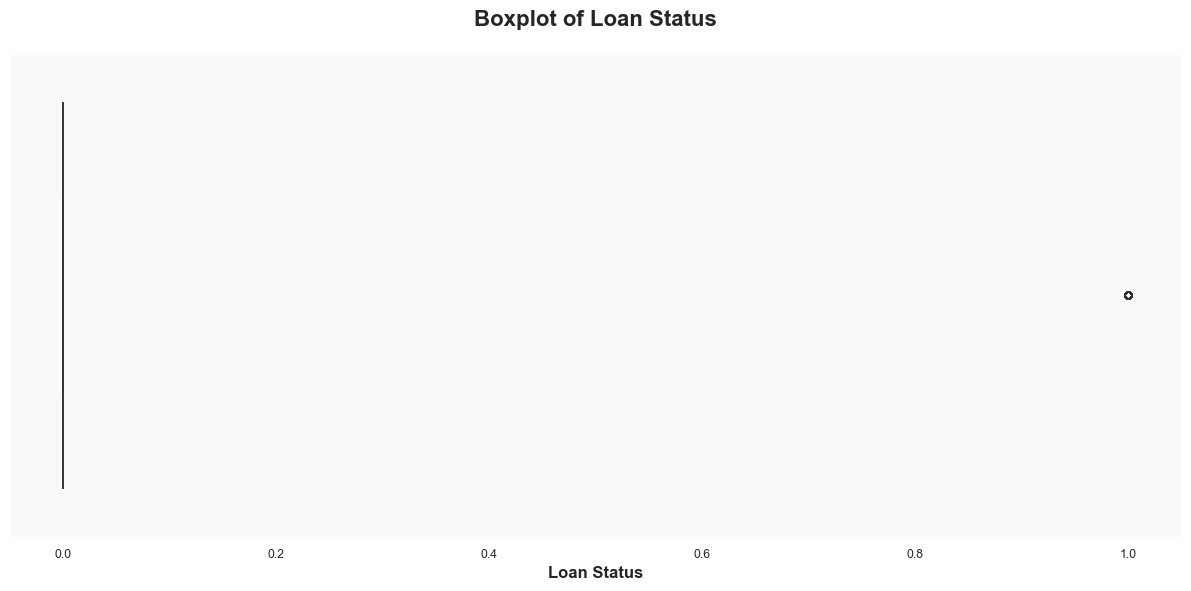

In [27]:
## Check for outliers in numeric columns 
def plot_boxplots(df, num_cols):
    for col in num_cols:
        plt.figure(figsize=(12, 6))
        
        # Create boxplot with improved styling
        sns.boxplot(data=df, x=col, color=cls, fliersize=5, linewidth=1.2)
        
        # Styling improvements
        plt.title(f"Boxplot of {col.replace('_', ' ').title()}", fontsize=16, fontweight='bold', pad=20)
        plt.xlabel(col.replace('_', ' ').title(), fontsize=12, fontweight='bold')
        plt.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
        plt.tight_layout()
        
        # Add subtle background color
        plt.gca().set_facecolor('#f8f9fa')
        
        plt.show()

plot_boxplots(df, num_cols)

## Base Moddeling

In [28]:
## Encode categorical variables
from sklearn.preprocessing import OrdinalEncoder

# Create an OrdinalEncoder instance
encoder = OrdinalEncoder()

# Fit and transform the categorical columns
df[cat_cols] = encoder.fit_transform(df[cat_cols])

# Check the encoded DataFrame
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,0.0,4.0,71948.0,0,3.0,35000.0,4.0,16.02,0.49,3.0,561,0.0,1
1,21.0,0.0,3.0,12282.0,0,2.0,1000.0,1.0,11.14,0.08,2.0,504,1.0,0
2,25.0,0.0,3.0,12438.0,3,0.0,5500.0,3.0,12.87,0.44,3.0,635,0.0,1
3,23.0,0.0,1.0,79753.0,0,3.0,35000.0,3.0,15.23,0.44,2.0,675,0.0,1
4,24.0,1.0,4.0,66135.0,1,3.0,35000.0,3.0,14.27,0.53,4.0,586,0.0,1


In [29]:
## Split the dataset into features and target variable
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Decision Tree Classifier Accuracy: 0.90


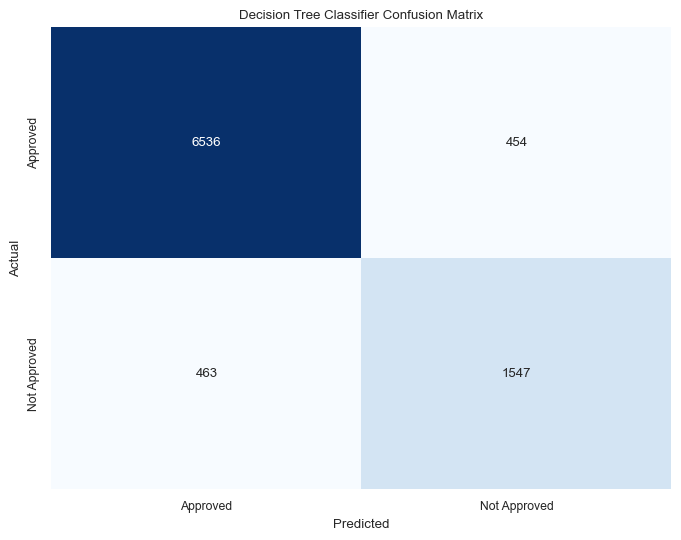

Decision Tree Classifier Classification Report:
               precision    recall  f1-score   support

     Approved       0.93      0.94      0.93      6990
 Not Approved       0.77      0.77      0.77      2010

     accuracy                           0.90      9000
    macro avg       0.85      0.85      0.85      9000
 weighted avg       0.90      0.90      0.90      9000



In [31]:
## Baseline model: Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Fit the model
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Classifier Accuracy: {dt_accuracy:.2f}")
# Confusion Matrix
dt_cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Approved', 'Not Approved'], yticklabels=['Approved', 'Not Approved'])
plt.title("Decision Tree Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
# Classification Report
print("Decision Tree Classifier Classification Report:")    
print(classification_report(y_test, y_pred_dt, target_names=['Approved', ' Not Approved']))

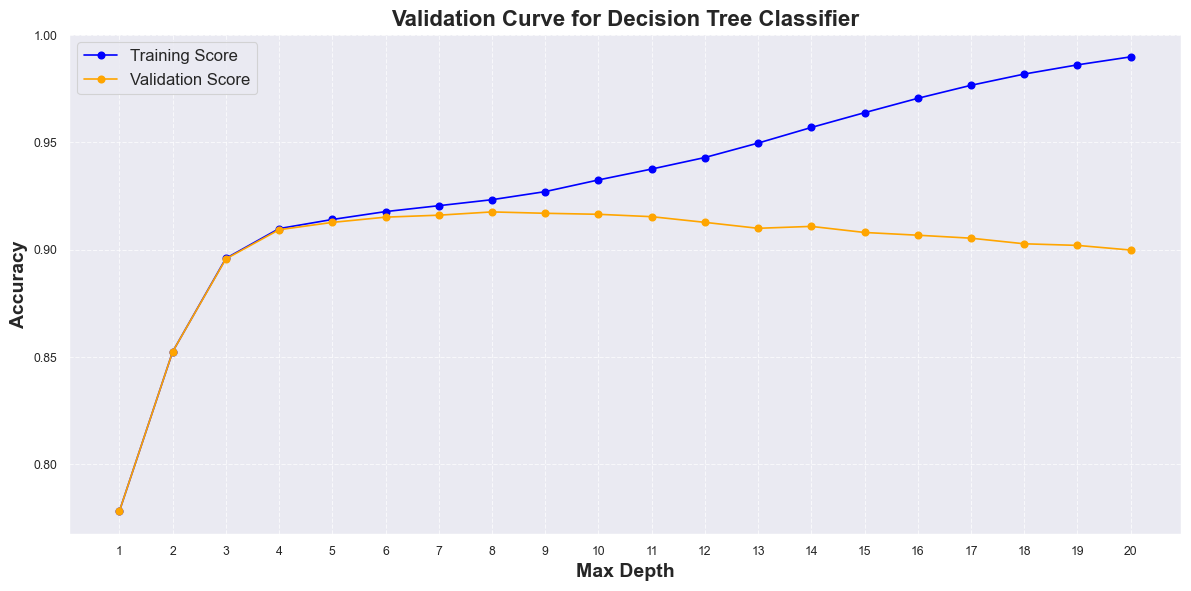

In [32]:
## Check if model is overfitting: compare training and validation loss while training
from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(
    dt_model, X_train, y_train, param_name="max_depth",
    param_range=np.arange(1, 21), cv=5, scoring="accuracy"
)

plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, 21), np.mean(train_scores, axis=1), label='Training Score', color='blue', marker='o')
plt.plot(np.arange(1, 21), np.mean(test_scores, axis=1),
            label='Validation Score', color='orange', marker='o')
plt.title("Validation Curve for Decision Tree Classifier", fontsize=16, fontweight='bold')
plt.xlabel("Max Depth", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy", fontsize=14, fontweight='bold')
plt.xticks(np.arange(1, 21))
plt.grid(True, linestyle='--', alpha=0.7)   
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

Random Forest Classifier Accuracy: 0.93


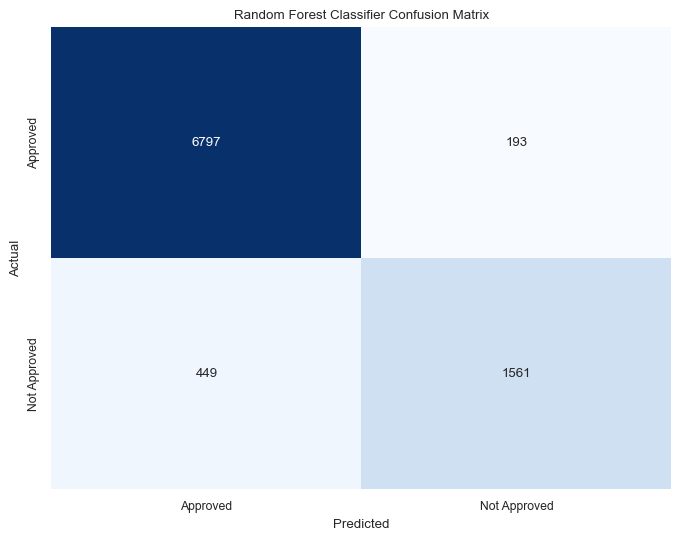

Random Forest Classifier Classification Report:
               precision    recall  f1-score   support

     Approved       0.94      0.97      0.95      6990
 Not Approved       0.89      0.78      0.83      2010

     accuracy                           0.93      9000
    macro avg       0.91      0.87      0.89      9000
 weighted avg       0.93      0.93      0.93      9000



In [34]:
## fit a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
# Evaluate the model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Classifier Accuracy: {rf_accuracy:.2f}")
# Confusion Matrix
rf_cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Approved', 'Not Approved'], yticklabels=['Approved', 'Not Approved'])
plt.title("Random Forest Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
# Classification Report
print("Random Forest Classifier Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Approved', ' Not Approved']))

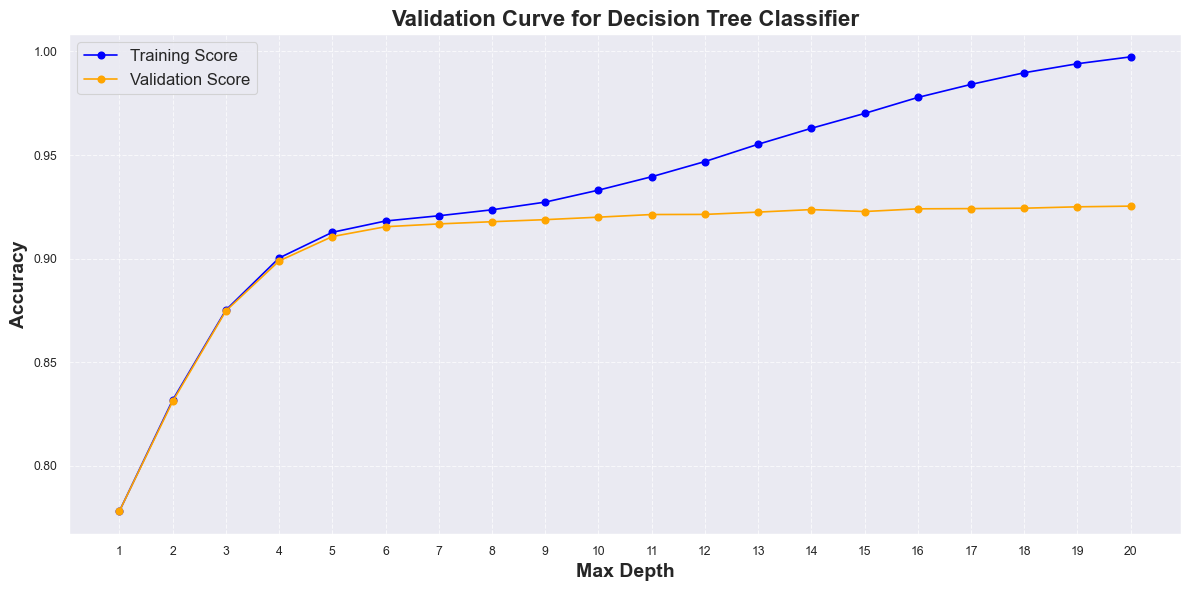

In [35]:
## Check if model is overfitting: compare training and validation loss while training
from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(
    rf_model, X_train, y_train, param_name="max_depth",
    param_range=np.arange(1, 21), cv=5, scoring="accuracy"
)

plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, 21), np.mean(train_scores, axis=1), label='Training Score', color='blue', marker='o')
plt.plot(np.arange(1, 21), np.mean(test_scores, axis=1),
            label='Validation Score', color='orange', marker='o')
plt.title("Validation Curve for Decision Tree Classifier", fontsize=16, fontweight='bold')
plt.xlabel("Max Depth", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy", fontsize=14, fontweight='bold')
plt.xticks(np.arange(1, 21))
plt.grid(True, linestyle='--', alpha=0.7)   
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

## Balance our dataset. And see if accuracy improves

Random Forest Classifier Accuracy after Oversampling: 0.93


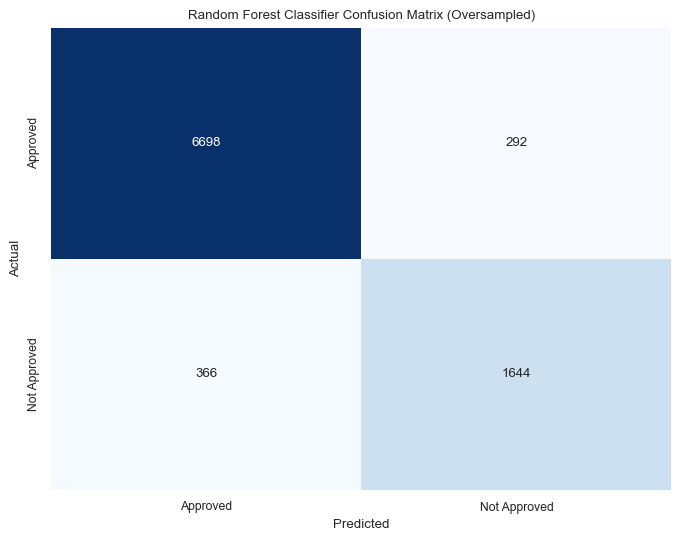

Random Forest Classifier Classification Report (Oversampled):
               precision    recall  f1-score   support

     Approved       0.95      0.96      0.95      6990
 Not Approved       0.85      0.82      0.83      2010

     accuracy                           0.93      9000
    macro avg       0.90      0.89      0.89      9000
 weighted avg       0.93      0.93      0.93      9000



In [36]:
# fit the model with oversampling
from imblearn.over_sampling import RandomOverSampler

# Create an instance of RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Fit and resample the training data
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Fit the Random Forest model on the resampled data
rf_model_resampled = RandomForestClassifier(random_state=42)
rf_model_resampled.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_rf_resampled = rf_model_resampled.predict(X_test)

# Evaluate the model
rf_accuracy_resampled = accuracy_score(y_test, y_pred_rf_resampled)
print(f"Random Forest Classifier Accuracy after Oversampling: {rf_accuracy_resampled:.2f}")
# Confusion Matrix
rf_cm_resampled = confusion_matrix(y_test, y_pred_rf_resampled)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm_resampled, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Approved', 'Not Approved'], yticklabels=['Approved', 'Not Approved'])
plt.title("Random Forest Classifier Confusion Matrix (Oversampled)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
# Classification Report
print("Random Forest Classifier Classification Report (Oversampled):")
print(classification_report(y_test, y_pred_rf_resampled, target_names=['Approved', ' Not Approved']))

Random Forest Classifier Accuracy after Undersampling: 0.89


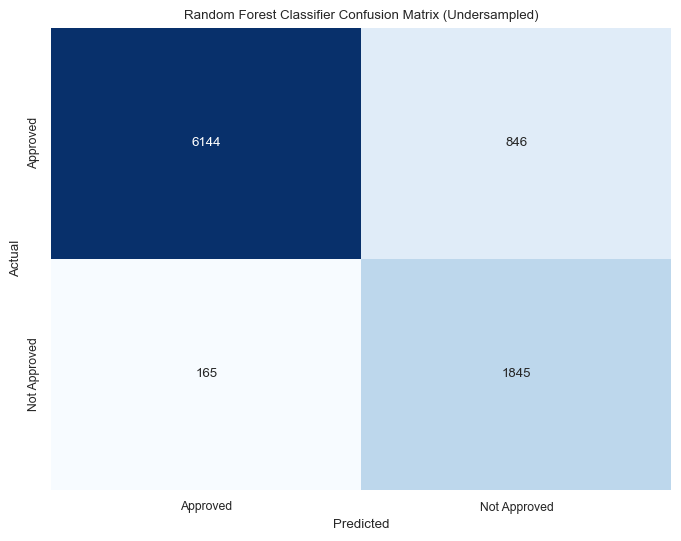

Random Forest Classifier Classification Report (Undersampled):
               precision    recall  f1-score   support

     Approved       0.97      0.88      0.92      6990
 Not Approved       0.69      0.92      0.78      2010

     accuracy                           0.89      9000
    macro avg       0.83      0.90      0.85      9000
 weighted avg       0.91      0.89      0.89      9000



In [39]:
## under sampling
from imblearn.under_sampling import RandomUnderSampler

# Create an instance of RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
# Fit and resample the training data
X_resampled_under, y_resampled_under = rus.fit_resample(X_train, y_train
)   
# Fit the Random Forest model on the resampled data
rf_model_resampled_under = RandomForestClassifier(random_state=42)
rf_model_resampled_under.fit(X_resampled_under, y_resampled_under)  
# Make predictions on the test set
y_pred_rf_resampled_under = rf_model_resampled_under.predict(X_test)
# Evaluate the model
rf_accuracy_resampled_under = accuracy_score(y_test, y_pred_rf_resampled_under)
print(f"Random Forest Classifier Accuracy after Undersampling: {rf_accuracy_resampled_under:.2f}")
# Confusion Matrix
rf_cm_resampled_under = confusion_matrix(y_test, y_pred_rf_resampled_under)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm_resampled_under, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Approved', 'Not Approved'], yticklabels=['Approved', 'Not Approved'])
plt.title("Random Forest Classifier Confusion Matrix (Undersampled)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
# Classification Report
print("Random Forest Classifier Classification Report (Undersampled):")
print(classification_report(y_test, y_pred_rf_resampled_under, target_names=['Approved', ' Not Approved']))

In [37]:
# Hyperparameter tuning using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 80, 100, 150, 180, 200],
    'max_depth': [None, 1, 4, 6, 10, 15, 20, 30],
    'min_samples_split': [2, 3,4, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6],
    'bootstrap': [True, False]
}

# Create a RandomizedSearchCV instance
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid,
                               n_iter=100, cv=3, verbose=2, random_state=42,
                                 n_jobs=-1, scoring='accuracy')

# Fit the RandomizedSearchCV
rf_random.fit(X_train, y_train)

# Get the best parameters
best_params = rf_random.best_params_

print("Best Parameters from RandomizedSearchCV:")
print(best_params)

# print the best score
best_score = rf_random.best_score_

print(f"Best Score from RandomizedSearchCV: {best_score:.2f}")


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters from RandomizedSearchCV:
{'n_estimators': 80, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}
Best Score from RandomizedSearchCV: 0.93


Random Forest Classifier Accuracy with Class Weights: 0.93


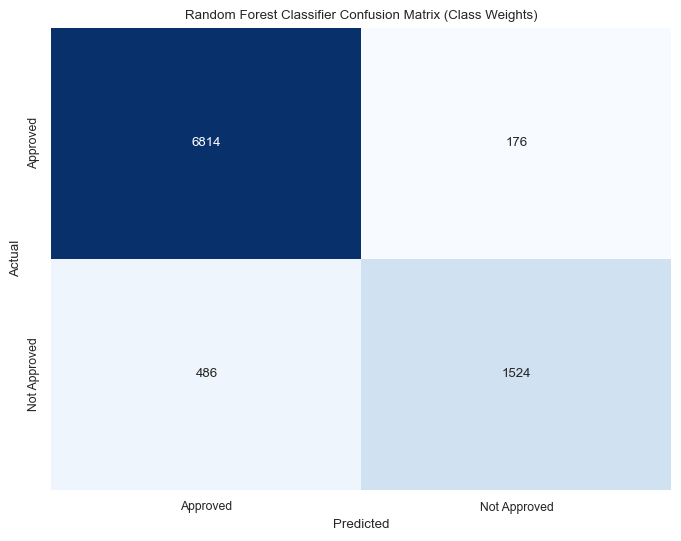

Random Forest Classifier Classification Report (Class Weights):
               precision    recall  f1-score   support

     Approved       0.93      0.97      0.95      6990
 Not Approved       0.90      0.76      0.82      2010

     accuracy                           0.93      9000
    macro avg       0.91      0.87      0.89      9000
 weighted avg       0.93      0.93      0.92      9000



In [38]:
class_0_weights = len(y_train) / (2 * np.bincount(y_train)[0])
class_1_weights = len(y_train) / (2 * np.bincount(y_train)[1])

# Create a Random Forest model with class weights
rf_model_weighted = RandomForestClassifier(random_state=42, class_weight={0: class_0_weights, 1: class_1_weights})
# Fit the model
rf_model_weighted.fit(X_train, y_train)
# Make predictions
y_pred_rf_weighted = rf_model_weighted.predict(X_test)
# Evaluate the model
rf_accuracy_weighted = accuracy_score(y_test, y_pred_rf_weighted)
print(f"Random Forest Classifier Accuracy with Class Weights: {rf_accuracy_weighted:.2f}")
# Confusion Matrix
rf_cm_weighted = confusion_matrix(y_test, y_pred_rf_weighted)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm_weighted, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Approved', 'Not Approved'], yticklabels=['Approved', 'Not Approved'])
plt.title("Random Forest Classifier Confusion Matrix (Class Weights)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
# Classification Report
print("Random Forest Classifier Classification Report (Class Weights):")
print(classification_report(y_test, y_pred_rf_weighted, target_names=['Approved', ' Not Approved']))

In [ ]:
## Do model explainability 
import shap

explainer = shap.TreeExplainer(dt_model)
explanation = explainer(Xd)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

shap.plots.beeswarm(explanation)